In [1]:
import datetime

import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv")
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

df["value"] = np.log1p(df["value"])

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="timestamp"
)
train_data.head()

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0.0
HOBBIES_1_002_CA_1,2011-01-29,0.0
HOBBIES_1_003_CA_1,2011-01-29,0.0
HOBBIES_1_004_CA_1,2011-01-29,0.0
HOBBIES_1_005_CA_1,2011-01-29,0.0


In [3]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    path="autogluon-m5-daily",
    target="value",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=12000,
);

Beginning AutoGluon training... Time limit = 12000s
AutoGluon will save models to '/notebooks/time-series-llm/autogluon-m5-daily'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.3
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #46~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jun 7 15:06:04 UTC 20
CPU Count:          8
Pytorch Version:    2.9.1+cu128
CUDA Version:       12.8
GPU Memory:         GPU 0: 15.72/15.72 GB
Total GPU Memory:   Free: 15.72 GB, Allocated: 0.00 GB, Total: 15.72 GB
GPU Count:          1
Memory Avail:       37.45 GB / 44.08 GB (84.9%)
Disk Space Avail:   188665.86 GB / 438354.34 GB (43.0%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 'auto',
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123

In [4]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.409497,242.470636,237.991029,10
1,TemporalFusionTransformer,-1.411905,21.818581,346.388686,8
2,Chronos2,-1.427427,180.743367,199.082060,4
3,Chronos2SmallFineTuned,-1.432151,39.635725,257.279865,5
4,ChronosWithRegressor[bolt_small],-1.456587,36.809803,84.691269,7
5,DeepAR,-1.461583,71.250065,283.159553,9
6,AutoETS,-1.693138,685.567911,715.434014,6
7,DirectTabular,-1.769022,40.006766,138.519747,3
8,SeasonalNaive,-1.851797,20.695438,52.519441,1
9,RecursiveTabular,-1.904660,53.149856,294.828219,2


In [5]:
predictions = predictor.predict(train_data)
predictions[predictions < 0.0] = 0.0
predictions = np.expm1(predictions)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3  \
item_id            timestamp                                            
HOBBIES_1_001_CA_1 2016-04-25  0.625560  0.008232  0.002921  0.014403   
                   2016-04-26  0.597248  0.006898  0.000000  0.011394   
                   2016-04-27  0.611083  0.007315  0.000000  0.009756   
                   2016-04-28  0.672441  0.009658  0.003636  0.011844   
                   2016-04-29  0.730337  0.011674  0.008150  0.022237   
...                                 ...       ...       ...       ...   
FOODS_3_827_WI_3   2016-05-18  0.021459  0.000000  0.000171  0.000000   
                   2016-05-19  0.021085  0.000000  0.000886  0.000000   
                   2016-05-20  0.021596  0.000000  0.000098  0.000000   
                   2016-05-21  0.019165  0.000000  0.000000  0.000000   
                   2016-05-22  0.006959  0.000000  0.000000  0.000000   

                                    0.4       0.5       0.6       0.7  \
item_id            timestamp                                            
HOBBIES_1_001_CA_1 2016-04-25  0.136293  0.625560  0.883945  1.170745   
                   2016-04-26  0.109606  0.597248  0.883990  1.152407   
                   2016-04-27  0.116379  0.611083  0.888574  1.167488   
                   2016-04-28  0.184715  0.672441  0.918645  1.244721   
                   2016-04-29  0.314898  0.730337  0.982308  1.387813   
...                                 ...       ...       ...       ...   
FOODS_3_827_WI_3   2016-05-18  0.006783  0.021459  0.113527  0.845324   
                   2016-05-19  0.008416  0.021085  0.121081  0.907034   
                   2016-05-20  0.008419  0.021596  0.151532  1.054468   
                   2016-05-21  0.005093  0.019165  0.215981  1.215970   
                   2016-05-22  0.000000  0.006959  0.324706  1.306318   

                                    0.8       0.9  
item_id            timestamp                       
HOBBIES_1_001_CA_1 2016-04-25  1.719089  2.236371  
                   2016-04-26  1.720804  2.228377  
                   2016-04-27  1.747231  2.254436  
                   2016-04-28  1.800062  2.330665  
                   2016-04-29  1.888457  2.452681  
...                                 ...       ...  
FOODS_3_827_WI_3   2016-05-18  1.868958  2.988134  
                   2016-05-19  2.032596  3.179515  
                   2016-05-20  2.252312  3.469956  
                   2016-05-21  2.347176  3.658602  
                   2016-05-22  2.291366  3.729539  

[853720 rows x 10 columns]

In [6]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]]
test_df = test_df.melt(id_vars="id", var_name="timestamp", value_name="value")

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="timestamp"
)
test_data

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0
HOBBIES_1_002_CA_1,2011-01-29,0
HOBBIES_1_003_CA_1,2011-01-29,0
HOBBIES_1_004_CA_1,2011-01-29,0
HOBBIES_1_005_CA_1,2011-01-29,0
...,...,...
FOODS_3_823_WI_3,2016-05-22,1
FOODS_3_824_WI_3,2016-05-22,0
FOODS_3_825_WI_3,2016-05-22,2


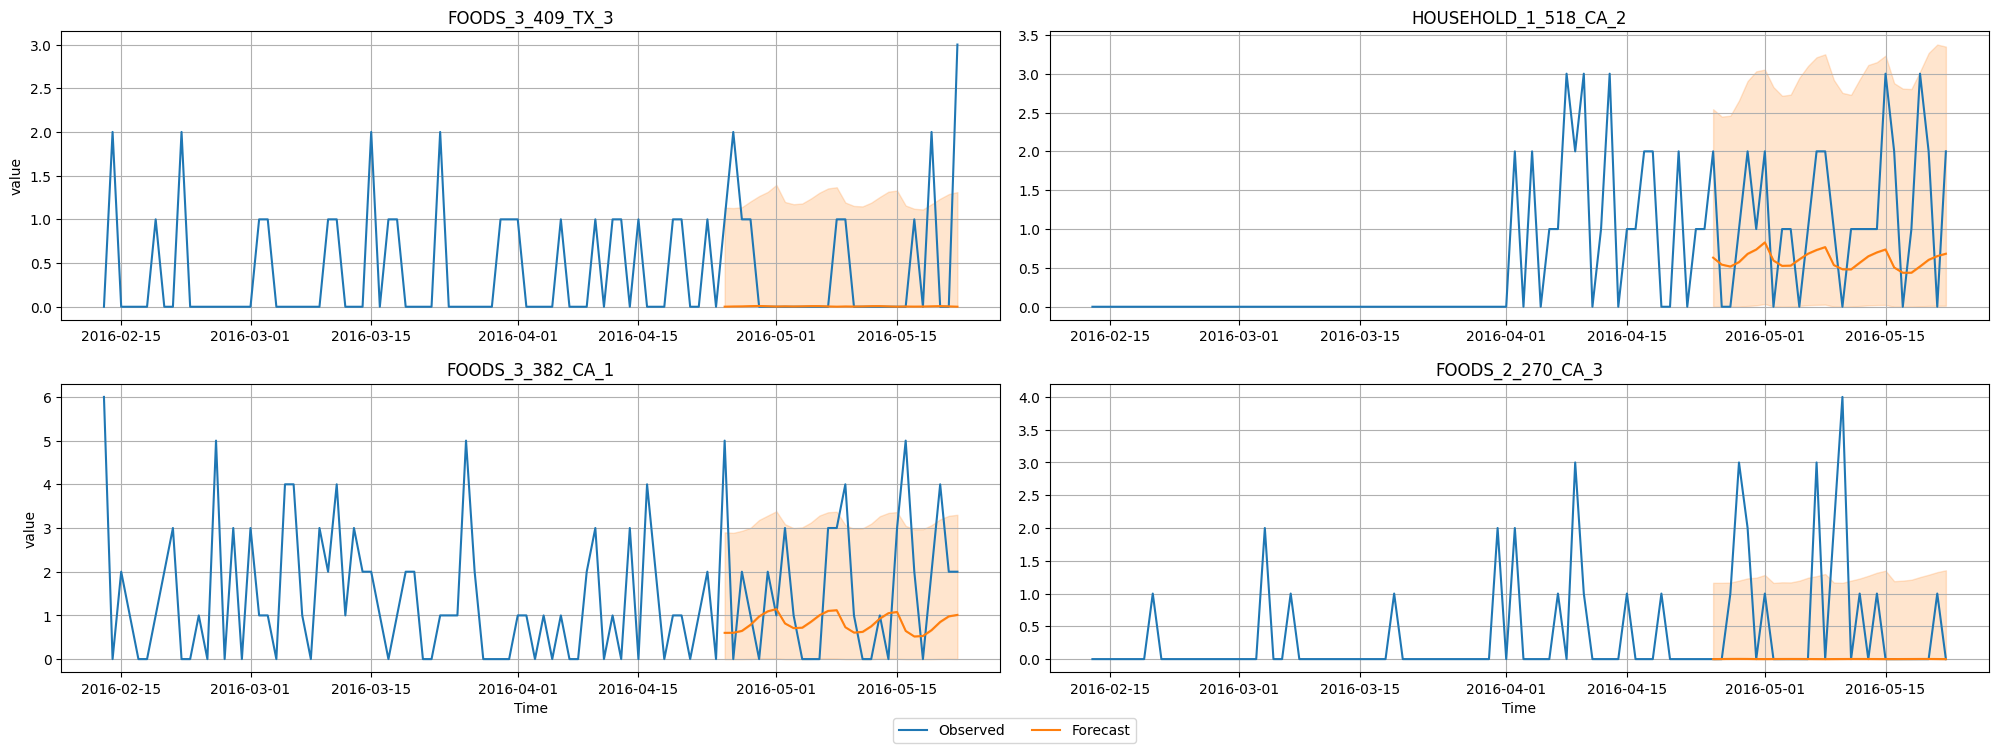

In [7]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=100, max_num_item_ids=4);

In [8]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.341851,-1.409497,257.808471,242.470636,237.991029,10
1,Chronos2,-1.344719,-1.427427,181.035275,180.743367,199.082060,4
2,TemporalFusionTransformer,-1.350101,-1.411905,24.845148,21.818581,346.388686,8
3,Chronos2SmallFineTuned,-1.350574,-1.432151,51.603455,39.635725,257.279865,5
4,ChronosWithRegressor[bolt_small],-1.363892,-1.456587,40.592610,36.809803,84.691269,7
5,DeepAR,-1.365257,-1.461583,90.459534,71.250065,283.159553,9
6,AutoETS,-1.593468,-1.693138,692.929619,685.567911,715.434014,6
7,DirectTabular,-1.639076,-1.769022,106.553560,40.006766,138.519747,3
8,SeasonalNaive,-1.810144,-1.851797,23.728247,20.695438,52.519441,1
9,RecursiveTabular,-1.838020,-1.904660,63.332273,53.149856,294.828219,2
